# Black Friday Demo Feature Importance Analysis

In [1]:
from google.cloud import aiplatform
from google.cloud import aiplatform_v1beta1
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from google.cloud import bigquery
from google.cloud.aiplatform_v1beta1.types import ExplanationParameters, SampledShapleyAttribution
from google.cloud.aiplatform_v1beta1.types import ExplanationMetadata
import shap
import xgboost as xgb
import matplotlib.pyplot as plt
import joblib
from sklearn.model_selection import train_test_split

Using `tqdm.autonotebook.tqdm` in notebook mode. Use `tqdm.tqdm` instead to force console mode (e.g. in jupyter console)


## Initialization

In [20]:
# Initialize the AI Platform client with your project and location
project = "aa-ai-specialisation"
location = "us-central1"
endpoint_id = "5557804779012358144"
api_endpoint = f"{location}-aiplatform.googleapis.com"
client_options = {"api_endpoint": api_endpoint}
client = aiplatform_v1beta1.PredictionServiceClient(client_options=client_options)

## Loading Data

In [3]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [6]:
%%bigquery test_df
SELECT * FROM `aa-ai-specialisation.black_friday.preprocessed_test_df`

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
test_df

,User_ID,Product_ID,Gender,Age,Occupation,Stay_In_Current_City_Years,Marital_Status,Product_Category_1,Product_Category_2,Product_Category_3,missing_Product_Category_2,missing_Product_Category_3,City_A,City_B,City_C
0,1003521,P00221442,0,2,0,3,0,1,2,5,0,0,0,1,0
1,1003521,P00003442,0,2,0,3,0,4,5,8,0,0,0,1,0
2,1003521,P00157642,0,2,0,3,0,1,14,16,0,0,0,1,0
3,1003521,P00058142,0,2,0,3,0,3,4,12,0,0,0,1,0
4,1003521,P00087142,0,2,0,3,0,13,14,16,0,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
233594,1003261,P00033942,0,4,20,1,1,5,0,0,1,1,0,1,0
233595,1003261,P00134142,0,4,20,1,1,5,0,0,1,1,0,1,0
233596,1003261,P00129642,0,4,20,1,1,5,0,0,1,1,0,1,0
233597,1003261,P00010242,0,4,20,1,1,5,0,0,1,1,0,1,0


## Prepare the Instances for Explanation

In [45]:
# Number of instances you want to use
i=0   # Adjust this based on how many instances you want to send

# Prepare named instances

instance = {
    "Gender": int(test_df['Gender'].iloc[i]),
    "Age": int(test_df['Age'].iloc[i]),
    "Occupation": int(test_df['Occupation'].iloc[i]),
    "Stay_In_Current_City_Years": int(test_df['Stay_In_Current_City_Years'].iloc[i]),
    "Marital_Status": int(test_df['Marital_Status'].iloc[i]),
    "Product_Category_1": int(test_df['Product_Category_1'].iloc[i]),
    "Product_Category_2": int(test_df['Product_Category_2'].iloc[i]),
    "Product_Category_3": int(test_df['Product_Category_3'].iloc[i]),
    "missing_Product_Category_2": int(test_df['missing_Product_Category_2'].iloc[i]),
    "missing_Product_Category_3": int(test_df['missing_Product_Category_3'].iloc[i]),
    "City_A": int(test_df['City_A'].iloc[i]),
    "City_B": int(test_df['City_B'].iloc[i]),
    "City_C": int(test_df['City_C'].iloc[i])}

   
instances=[instance]

In [46]:
# Number of instances you want to use
i=0   # Adjust this based on how many instances you want to send

# Prepare named instances

instance = [
    int(test_df['Gender'].iloc[i]),
    int(test_df['Age'].iloc[i]),
    int(test_df['Occupation'].iloc[i]),
    int(test_df['Stay_In_Current_City_Years'].iloc[i]),
    int(test_df['Marital_Status'].iloc[i]),
    int(test_df['Product_Category_1'].iloc[i]),
    int(test_df['Product_Category_2'].iloc[i]),
    int(test_df['Product_Category_3'].iloc[i]),
    int(test_df['missing_Product_Category_2'].iloc[i]),
    int(test_df['missing_Product_Category_3'].iloc[i]),
    int(test_df['City_A'].iloc[i]),
    int(test_df['City_B'].iloc[i]),
    int(test_df['City_C'].iloc[i])]

   
instances=[instance]

In [47]:
instances

[[0, 2, 0, 3, 0, 1, 2, 5, 0, 0, 0, 1, 0]]

## Set Up Explanation Parameters and Metadata

In [48]:
# Explanation parameters
explanation_parameters = ExplanationParameters(
    sampled_shapley_attribution=SampledShapleyAttribution(path_count=10)
)

# Explanation metadata
explanation_metadata = ExplanationMetadata(
    inputs={
        "Gender": ExplanationMetadata.InputMetadata(),
        "Age": ExplanationMetadata.InputMetadata(),
        "Occupation": ExplanationMetadata.InputMetadata(),
        "Stay_In_Current_City_Years": ExplanationMetadata.InputMetadata(),
        "Marital_Status": ExplanationMetadata.InputMetadata(),
        "Product_Category_1": ExplanationMetadata.InputMetadata(),
        "Product_Category_2": ExplanationMetadata.InputMetadata(),
        "Product_Category_3": ExplanationMetadata.InputMetadata(),
        "missing_Product_Category_2": ExplanationMetadata.InputMetadata(),
        "missing_Product_Category_3": ExplanationMetadata.InputMetadata(),
        "City_A": ExplanationMetadata.InputMetadata(),
        "City_B": ExplanationMetadata.InputMetadata(),
        "City_C": ExplanationMetadata.InputMetadata()
    },
    outputs={"predicted_value": ExplanationMetadata.OutputMetadata()}
)


# Combine parameters and metadata into explanation spec
explanation_spec = aiplatform_v1beta1.ExplanationSpec(
    parameters=explanation_parameters,
    metadata=explanation_metadata
)


## Create and Send the Explain Request

In [49]:
# Endpoint for prediction and explanation
endpoint = client.endpoint_path(project=project, location=location, endpoint=endpoint_id)

# Create and send the explain request
response = client.explain(
    endpoint=endpoint,
    instances=instances,
    
)

# # Interpret and print the explanations
# for explanation in response.explanations:
#     print(f"Attributions: {explanation.attributions}")


InvalidArgument: 400 {"error": "Unable to explain the requested instance(s) because: Nameless inputs are allowed only if there is a single input in the explanation metadata."}

## XGBoost Built-in Feature Importance

In [2]:
# loading the xgboost model
model_filename = './model_checkpoints/xgboost_model.joblib'
xgboost_model = joblib.load(model_filename)

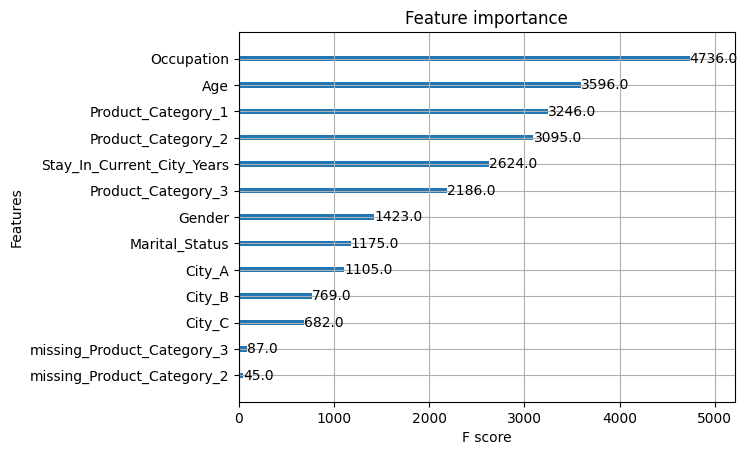

In [3]:
# Plot feature importance
xgb.plot_importance(xgboost_model,importance_type='weight')
plt.show()

In [4]:
%load_ext google.cloud.bigquery

The google.cloud.bigquery extension is already loaded. To reload it, use:
  %reload_ext google.cloud.bigquery


In [5]:
%%bigquery train_df
SELECT * FROM `aa-ai-specialisation.black_friday.preprocessed_train_df`

Query is running:   0%|          |

Downloading:   0%|          |

In [6]:
%%bigquery test_df
SELECT * FROM `aa-ai-specialisation.black_friday.test`

Query is running:   0%|          |

Downloading:   0%|          |

In [7]:
train_df_copy = train_df.copy()
test_df_copy = test_df.copy()

X= train_df_copy.drop(columns=['User_ID', 'Product_ID','Purchase'])
y = train_df_copy['Purchase'].astype(int)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42, shuffle=True)

<AxesSubplot:title={'center':'Important features of XGBoost Regressor'}>

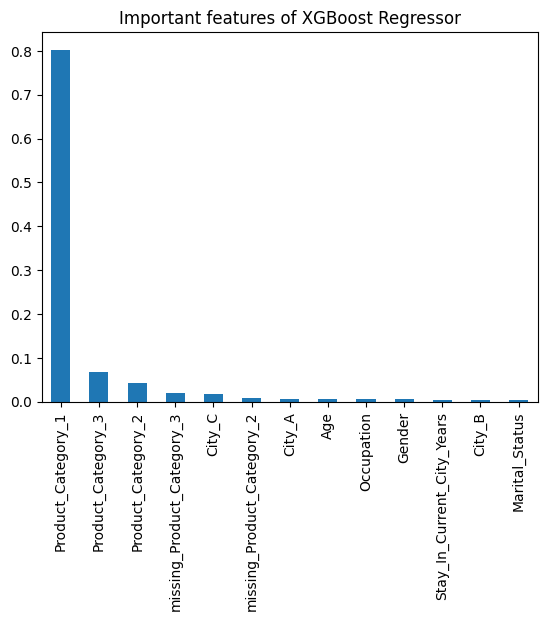

In [8]:
xgb_features = pd.Series(xgboost_model.feature_importances_, X.columns).sort_values(ascending=False)
xgb_features.plot(kind='bar', title='Important features of XGBoost Regressor')

## SHAP Method for Feature Importance

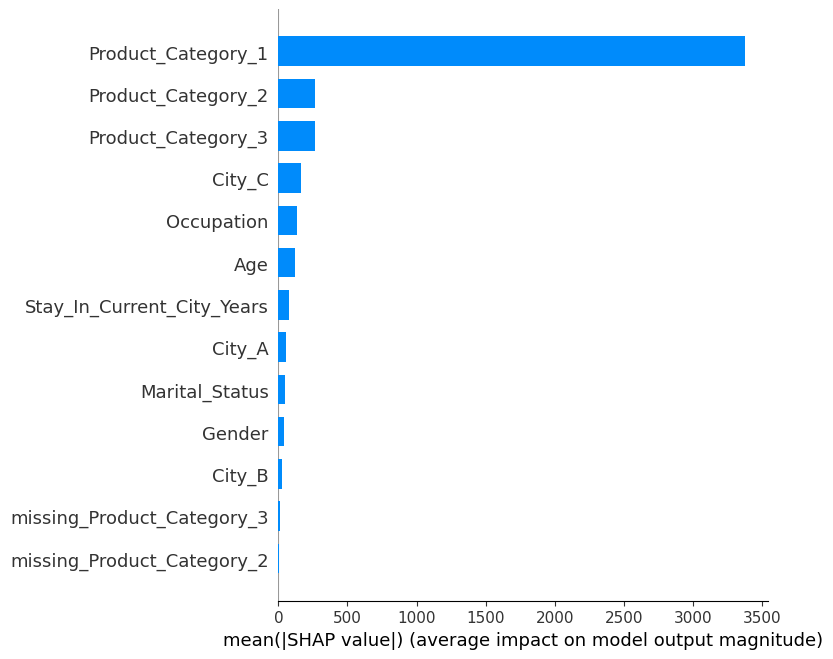

In [9]:
import shap

# Create a SHAP explainer with 'interventional' feature perturbation
explainer = shap.TreeExplainer(xgboost_model, feature_perturbation='interventional')

# Calculate SHAP values for X_train
shap_values = explainer.shap_values(X_train, check_additivity=False)

# Plot the SHAP values
shap.summary_plot(shap_values, X_train, plot_type="bar")
